**This exercise is part of the [Token Embeddings](https://www.kaggle.com/datasniffer/nlp-token-embeddings) tutorial**

---


# Train your own vector embeddings

BERT works with vector embeddings—numerical vectors that represents the contextualized meaning of words in a sequences. They are state of the art representations of semantics and evolved out of more simple text embeddings such as Word2Vec and GloVe.

As aluded to in the tutorial (tutorial 2 for this NLP course), there is an entire zoo out there of pre-trained word embeddings that you can download from the internet and use to your advantage; including the most widely known:

- FastText (multiple dimensions available, for many languages)
- GloVe (multiple dimensions available, for English)
- Word2vec (multiple dimensions available, for multiple languages)

Because these word vectors have been trained on huge amounts of data, they are of very high quality. However, this also means that they may not contain words or tokens or symbols that are relevant to your task at hand. In those cases, you may very well benefit from creating your own word (token) embeddings, customized specifically for the data you have at hand.

In this exercise you will create your own word embeddings. But instead of using the approach demonstrated in the tutorial, we'll use a library called `gensim` which makes this a little easier and faster.


Parts of this exercise are based on [this Kaggle notebook](https://www.kaggle.com/code/chewzy/tutorial-how-to-train-your-custom-word-embedding). 

Let's get started. First, run the next code cell.

In [1]:
import pandas as pd
import numpy as np

# Set up code checking
from learntools.core import binder
binder.bind(globals())
from learntools_nlp_utility import *

print("\nSetup complete")


Setup complete


In [2]:
def cleanup_review(review):
    import re
    
    # Mr., Mrs., Dr., etc.
    review = re.sub("\s(Dr|Mr|Mrs|Ms|vs|U.S)\.\s", " \\1_ ", review)
    
    # . is going to be a token
    review = re.sub("\s+\.\s|(?<=\w)\.(?=[A-Z\W])|.$", " . ", review)
    
    # 's, 'd, 'll are going to be tokens
    review = re.sub("'(s|d|ll|ve)\s", " _\\1 ", review)
    
    # n't
    review = re.sub("n't\s", " not ", review)
    
    # .., ..., ...., etc. is going to be a token
    review = re.sub("\.{2,}", " ... ", review)
    
    # , is going to be a token
    review = re.sub("(?<=\w)([,!?])", " \\1 ", review)
    
    # \W is going to be a token
    # move text in parentheses to the back
    while re.findall("\s\(([^)]+)\)", review):
        review = re.sub("(.+?)\s\(([^)]+)\)[.!?]?(.+)", "\\1 \\3 <br />\\2 ", review) 
        
    # remove " and '
    review = re.sub("['\"()]", " ", review)
    
    # each white space is only one space
    review = re.sub("\s+"," ", review)
    
    return review

# Read in the data
newdat = pd.read_csv("../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

# Clean up the reviews
newdat['review'] = newdat.review.map(lambda x: cleanup_review(x).lower())
newdat

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production . <br /><br />th...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there _s a family where a little boy...,negative
4,petter mattei _s love in the time of money is ...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,"bad plot , bad dialogue , bad acting , idiotic...",negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i m going to have to disagree with the previou...,negative


# Step 1: Splitting texts into word sequences

As we did in the tutorial we need to split the review texts up into sentences/fragments, and then the sentences into word sequences. Write the code to split the sentences into lists of words (using a space as the split) in the list `train_sentences` below:

In [3]:
from itertools import chain

# The following splits reviews into fragments ('sentences') at the <br /> marks for you
sentences = newdat['review'].apply(lambda x: x.split("<br />")).values
sentences = chain(*sentences)

# Now split the sentences/fragments into word lists 
# YOUR CODE (1 to 4 lines of code):
train_sentences = [sentence.split(" ") for sentence in sentences]

In [4]:
# Check your work (Run this to get points!)
step_1.check()

# You can ask for a hint or the solution by uncommenting the following:
#step_1.hint()
step_1.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
# A three-lines solution:
train_sentences = []
for sentence in sentences:
   train_sentences.append(sentence.split(' '))

# A one-line solution (in case you're wondering):
train_sentences = list(map(lambda x: x.split(' '), sentences))

```

What we don't have to do is encode the words as integers; `gensim` will take care of that for us. What we do need to do is provide `gensim` with a function with which it can decide whether to keep a word or discard a word from the vocabulary

In [5]:
words = []
for sentence in train_sentences:
    words += sentence
vocab = set(words)

vocab = {word:0 for word in vocab}
for word in words:
    vocab[word] += 1
    
vocab = sorted(vocab.items(), key = lambda x: x[1], reverse=True)[:1000]
vocab = dict(vocab)

def trim_rule(word, count, min_count):
    # ignore args 'count' and 'min_count'
    from gensim import utils
    return utils.RULE_KEEP if word in vocab else utils.RULE_DISCARD
    

# Step 2: Learning word embeddings with `gensim`

We start with importing the `Word2Vec` module from the `gensim` library:

In [6]:
from gensim.models import Word2Vec

The `Word2Vec` needs as inputs

- The `sentences` broken up in tokens
- The embedding dimension (`vector_size`); we'll use 50 as in the tutorial
- A choice of architecture (0 for CBOW, 1 for Skip-gram); here we'll use CBOW
- A window size that defines how many words around the target word will be used as _context_; we'll use `window = 3` as we did in the tutorial
- Our rule for deciding whether to keep a word/token or discard it ([`trim_rule`](https://radimrehurek.com/gensim/models/word2vec.html))

Other than that, we can specify the maximum number of tokens in the vocabulary (`max_vocab_size`), the number of training `epochs` (which we set to 10). We can also specify the number of CPU cores that we want to use (`workers`); we have 4 so why not use them? And we can specify that the vocabulary should be sorted by descending frequency before assigning a numeric ID.

In [7]:
%%time

word2vec_model = Word2Vec(
    sentences = train_sentences, 
    sg = 0,
    vector_size = 50,
    window = 3,
    workers = 4,
    sorted_vocab = 1,
    epochs = 10,
    trim_rule = trim_rule,
    seed=101
)

CPU times: user 3min, sys: 1.31 s, total: 3min 1s
Wall time: 1min


The "cell magic" command `%%time` at the start of the cell is a feature from Jupyter that allows to quickly assess how long the excution of the code inside the cell takes. Here you can see that `Word2Vec` is very fast (at least, compared to the training of the `embedding_learner` from the tutorial.

The information about the word embeddings, including the vocabulary and the word-numeric ID mappings is stored in the `wv` (word vectors) component of the model. 

#### Analogical reasoning with word embeddings

The `wv` object also has a number of methods that can perform various word similarity tasks to evaluate the quality of the word vectors. For instance, the analogy

> Germany : Berlin ~ France : Paris

can be solved in terms of word embeddings by looking up the word embedding that is most similar to $\mathbf{w}_\text{germany} - \mathbf{w}_\text{berlin} + \mathbf{w}_\text{paris}$. Now, 'berlin', 'france', and 'paris' are not in our `vocab`ulary, but the similar analogy

> director : script ~ actor : role

consists of words in our vocabulary. 

This analogy can be solved with the `most_similar` method of the `word2vec_model.wv` object: It takes a list of words with a positive sign and a list of words with a negative sign, as in the expression $\mathbf{w}_\text{germany} - \mathbf{w}_\text{berlin} + \mathbf{w}_\text{paris}$:

In [8]:
# director : script ~ actor : role
word2vec_model.wv.most_similar(positive=['director', 'role'], negative=['script'])

[('career', 0.6891260147094727),
 ('lee', 0.6317877769470215),
 ('mr_', 0.6181329488754272),
 ('john', 0.6166422367095947),
 ('actor', 0.5996233224868774),
 ('de', 0.5967867374420166),
 ('star', 0.5815402269363403),
 ('performance', 0.571494460105896),
 ('george', 0.5684173107147217),
 ('paul', 0.5660404562950134)]

The correct words '_actor_' and '_actress_' are in the top 5 of most similar word embeddings!

Now use this function to solve the analogy

> man : boy ~ woman : girl

and store the result in the variable `analogy_sol`:

In [9]:
# Solve the analogy above with the fitted word2vec_model

# YOUR CODE (1 line of code)
analogy_sol = word2vec_model.wv.most_similar(positive=['man', 'woman'], negative=['boy'])
print(analogy_sol)

step_2.check()

# You can ask for a hint or the solution by uncommenting the following:
#step_2.hint()
#step_2.solution()

[('doctor', 0.7448320388793945), ('lady', 0.7261499166488647), ('child', 0.707827091217041), ('girl', 0.6732783317565918), ('killer', 0.6682304739952087), ('person', 0.6567999720573425), ('named', 0.6496866345405579), ('cop', 0.6482382416725159), ('herself', 0.6206503510475159), ('hero', 0.6115176677703857)]


<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

 
```python
word2vec_model.wv.most_similar(positive=['man', 'woman'], negative=['boy'])
```

Next you're going to use your own word embeddings to train a sentiment classifier.

# Step 3: Encoding the reviews

For the sentiment classification task you first need to encode the reviews. The sentences need to be split, and the words should be encoded with the `word2vec_model`'s vocabulary. It's vocabulary is available as a dictionary in the `word2vec_model.wv.key_to_index`. Complete the function below to encode the reviews using `word2vec_model.wv.key_to_index` to translate words to ID codes. Words not in the vocabulary should be encoded with 999:

In [10]:
# Complete the code for the function `review_encoder`

def review_encoder(review, max_length=256):
    review = review.replace(("<br />"), "").split()[:max_length]
    # YOUR CODE (1 to 3 lines of code):
    enc = []
    # print(word2vec_model.wv.key_to_index.keys())
    for word in review:
        if word in word2vec_model.wv.key_to_index.keys():
            enc.append(word2vec_model.wv.key_to_index[word])
        else:
            enc.append(999)
    enc = (enc + ([0]*max_length))[:max_length] # make all sequence lengths equal to max_length
    return enc


review_encoder(newdat.review.values[1])[:10]

[4, 385, 124, 364, 1, 0, 999, 999, 8, 56]

In [11]:
# Check your work to get the points(!)
step_3.check()
    
# You can ask for a hint or the solution by uncommenting the following:
#step_3.hint()
#step_3.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

 
```python
def review_encoder(review, max_length=256):
    review = review.split()[:max_length]
    w2i = word2vec_model.wv.key_to_index
    UNK_ID = len(w2i)-1
    enc = [w2i[word] if word in w2i else UNK_ID for word in review]
    enc = (enc + ([0]*max_length))[:max_length] # make all sequence lengths equal to max_length
    return enc

```

Now we can apply the `review_encoder` on the reviews in `newdat`, and store the encoded reviews in the `numpy` arrays `xtrain` and `ytrain`, in the same way as in the tutorial:

In [12]:
newdat['encoded_review'] = newdat.review.apply(review_encoder)
newdat['encoded_sentiment'] = newdat.sentiment.apply(lambda x: 1 if x == 'positive' else 0)
newdat

,review,sentiment,encoded_review,encoded_sentiment
0,one of the other reviewers has mentioned that ...,positive,"[30, 6, 0, 85, 999, 48, 999, 13, 106, 151, 42,...",1
1,a wonderful little production . <br /><br />th...,positive,"[4, 385, 124, 364, 1, 0, 999, 999, 8, 56, 999,...",1
2,i thought this was a wonderful way to spend ti...,positive,"[11, 199, 12, 16, 4, 385, 101, 7, 999, 63, 24,...",1
3,basically there _s a family where a little boy...,negative,"[666, 40, 15, 4, 230, 118, 4, 124, 416, 999, 4...",0
4,petter mattei _s love in the time of money is ...,positive,"[999, 999, 15, 117, 10, 0, 63, 6, 290, 8, 4, 9...",1
...,...,...,...,...
49995,i thought this movie did a down right good job...,positive,"[11, 199, 12, 20, 76, 4, 187, 205, 52, 291, 1,...",1
49996,"bad plot , bad dialogue , bad acting , idiotic...",negative,"[88, 120, 2, 88, 407, 2, 88, 119, 2, 999, 957,...",0
49997,i am a catholic taught in parochial elementary...,negative,"[11, 232, 4, 999, 999, 10, 999, 999, 999, 34, ...",0
49998,i m going to have to disagree with the previou...,negative,"[11, 146, 167, 7, 28, 7, 999, 18, 0, 894, 913,...",0


In [13]:
xtrain = np.array(list(newdat.encoded_review.values))
ytrain = np.array(list(newdat.encoded_sentiment.values))

# Step 4: Setting up the sentiment classifier

With the training data in the write format for Tensorflow, it's time to set up a sentiment classifier model. 

In [14]:
from tensorflow import keras

Make sure the model is properly set up and initialized. The word embeddings from `word2vec_model` are already extracted for you and stored in the `numpy` array `embeddings`. Also, most of the network is specified for you, including a `GRU` recurrent neural network layer for better performance:

In [15]:
# Complete the specification of the Keras model

# YOUR CODE (~ 5 lines of code to complete)
embeddings = word2vec_model.wv[vocab.keys()]
vocab_size = embeddings.shape[0]
embed_dim = embeddings.shape[1]
weights_initializer = keras.initializers.Constant(embeddings)

sentiment_classifier = keras.models.Sequential([
    keras.layers.Embedding(
        vocab_size, 
        embed_dim, 
        embeddings_initializer = weights_initializer, 
        trainable=False),
    keras.layers.GRU(embed_dim, activation='relu', return_sequences=True),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [16]:
# Check your work
step_4.check()

# You can ask for a hint or the solution by uncommenting the following:
#step_4.hint()
#step_4.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

 
```python

    embeddings = word2vec_model.wv[vocab.keys()]
    weight_initializer = keras.initializers.Constant(embeddings)
    inp_dim, out_dim = embeddings.shape

    sentiment_classifier = keras.models.Sequential([
        keras.layers.Embedding(output_dim=out_dim, input_dim=inp_dim, embeddings_initializer=weight_initializer, trainable=False),
        keras.layers.GRU(50, activation='relu', return_sequences=True),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
```

# Step 5: Train the sentiment classifier

Train the sentiment classifier. Train for 2 epoch's at a learning rate of 0.01 and 4 epochs at learning rate 0.0001. Use a batch size of 128, and a training-validation split of 80%-20%.

Epoch 1/2
313/313 [==============================] - 94s 295ms/step - loss: 0.4163 - accuracy: 0.8040 - val_loss: 0.3811 - val_accuracy: 0.8263
Epoch 2/2
313/313 [==============================] - 92s 292ms/step - loss: 0.3526 - accuracy: 0.8425 - val_loss: 0.3745 - val_accuracy: 0.8291
Epoch 1/4
313/313 [==============================] - 94s 294ms/step - loss: 0.3183 - accuracy: 0.8621 - val_loss: 0.3426 - val_accuracy: 0.8481
Epoch 2/4
313/313 [==============================] - 93s 296ms/step - loss: 0.3082 - accuracy: 0.8653 - val_loss: 0.3412 - val_accuracy: 0.8488
Epoch 3/4
313/313 [==============================] - 91s 290ms/step - loss: 0.3035 - accuracy: 0.8673 - val_loss: 0.3403 - val_accuracy: 0.8505
Epoch 4/4
313/313 [==============================] - 92s 293ms/step - loss: 0.3001 - accuracy: 0.8689 - val_loss: 0.3397 - val_accuracy: 0.8506


<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

 
```python

        # Training 2 epochs with learning rate 0.01:
        sentiment_classifier.compile(keras.optimizers.Adam(1e-2),'binary_crossentropy', metrics=['acc'])
        h = sentiment_classifier.fit(xtrain,ytrain, batch_size=32*4, epochs=2, validation_split=.2)

        # Training 4 epochs with learning rate 0.0001:
        sentiment_classifier.compile(keras.optimizers.Adam(1e-4),'binary_crossentropy', metrics=['acc'])
        h = sentiment_classifier.fit(xtrain,ytrain, batch_size=32*4, epochs=4, validation_split=.2)
        
        # Visualize loss and validation loss over epochs
        pd.DataFrame(h.history)[['acc','val_acc']].plot()
        
```

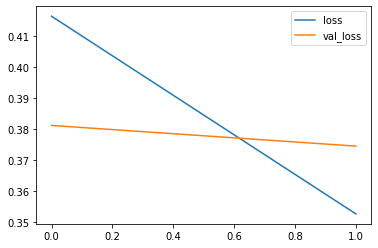

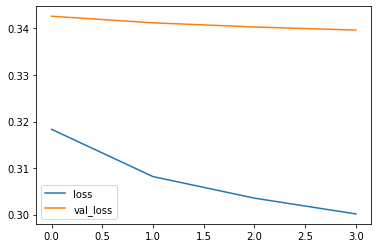

In [17]:
# Train the sentiment classifier

# YOUR CODE (3 to 4 lines of code)
sentiment_classifier.compile(keras.optimizers.Adam(0.01),'binary_crossentropy', metrics=['accuracy'])
h = sentiment_classifier.fit(
    xtrain, ytrain,
    batch_size=32*4,
    epochs=2,
    validation_split=.2
)
pd.DataFrame(h.history)[['loss','val_loss']].plot()

sentiment_classifier.compile(keras.optimizers.Adam(0.0001),'binary_crossentropy', metrics=['accuracy'])
h = sentiment_classifier.fit(
    xtrain, ytrain, epochs=4,
    batch_size=128,
    validation_split=0.2
)
pd.DataFrame(h.history)[['loss','val_loss']].plot()

# Check your work
step_5.check()

# You can ask for a hint or the solution by uncommenting the following:
#step_5.hint()
# step_5.solution()

# Step 6: Keep improving

You've built the necessary components to train a text classifier with using custom embeddings. What could you do further to optimize the model? How would you decide if the custom embeddings are even worth your while?

Run the next line to check your answer.

In [18]:
# Check your answer (Run this code cell to receive credit!)
step_6.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 

Possible avenues of improvement are increasing the embedding dimension (or decreasing embedding dimension of there is evidence of overtraining), considering different architectures, use more tokens from the reviews, increasing vocabulary size, trying a simple BoW model with conventional logistic regression, etc. Longer training of the embedding (i.e., more epochs) may also increase the quality of the embeddings and then, hopefully, improve performance. 

Are embeddings worth the effort? One reason to use embeddings is to reduce the input vector dimensions of text over one-hot encoding of all the words in the vocabulary. An benefit that arises from embeddings is that it makes the thought of the use of a recurrent neural layer (GRU) to contextualize individual embeddings more immediate: A sequence of vectors automatically suggests modeling the changes in the sequence as an (vector) auto-regression. However, all of that doesn't really logically require that the embedding vectors encode the correlation in use of the tokens. We could have met those objectives with randomly picked vectors as well.  

In fact when you replace the custom embeddings obtained with `gensim`'s `Word2Vec` with random vectors but use the same neural architecture you will see sentiment classification performance that is quite close! The architecture therefore appears to be more important than the embeddings—at least for sentiment classification of IMDB movie reviews.


## Keep Going

The next step is to dig a little deeper into [recurrent neural network layers](https://www.kaggle.com/datasniffer/nlp-recurrent-networks-for-entailment/).